# Deep Learning
## HW3 - Problem 1 


1.   Full Name: Ehsanollah Shourezari
2.   Student Number: 400206295

In [2]:
from google.colab import drive
from google.colab import files
import os
import torchvision
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as Fun
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor,Lambda
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from torchsummary import summary


In [3]:
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# files.upload() # upload kaggle.json
# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 /root/.kaggle/kaggle.json
# !kaggle datasets list
# !kaggle datasets download -d hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images
# !unzip shoe-vs-sandal-vs-boot-dataset-15k-images.zip

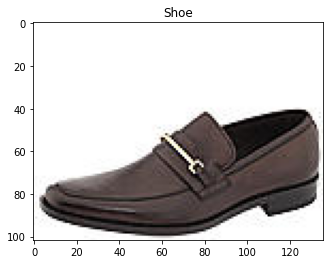

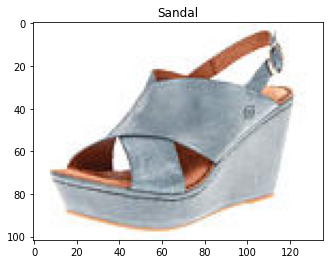

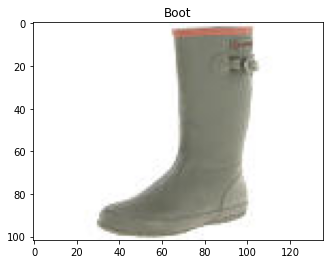

In [4]:
dir = "/content/drive/MyDrive/Shoe vs Sandal vs Boot Dataset" 
labels = os.listdir(dir)
for i in labels:
  sub_dir = os.path.join(dir,i)
  img = np.random.choice(os.listdir(sub_dir))
  img_dir = os.path.join(sub_dir, img)
  img = plt.imread(img_dir)
  plt.imshow(img)
  plt.title(i)
  plt.show()

In [5]:
sz1 = 64
transform = transforms.Compose([transforms.Resize((sz1, sz1)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
ds        = torchvision.datasets.ImageFolder(root= dir, transform=transform)

train_ds, test_ds = torch.utils.data.random_split(ds, [int(0.7 * len(ds)), int(0.3 * len(ds))])


In [6]:
def train_loop(dataloader, model, loss_fn, optimizer):

    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    tr_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            tr_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    tr_loss /= num_batches
    correct /= size
    print(f"Train : \n Accuracy: {(100*correct):>0.1f}%, Avg loss per Batch: {tr_loss:>8f} \n")
    return correct ,tr_loss

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test : \n Accuracy: {(100*correct):>0.1f}%, Avg loss per Batch: {test_loss:>8f} \n")
    return correct,test_loss

In [7]:
def MyModelAnalysis(data, model , model_name , Acc_tr_hist , Acc_te_hist , loss_tr_hist , loss_te_hist , Best_acc , epochs) :
    y_actual = []
    y_pred   = []
    for X, y in test_dl:
             pred     = model(X)
             pred_idx = pred.argmax(1)

             y_actual += y.tolist()
             y_pred   += pred_idx.tolist()


    conf_mat  = confusion_matrix(y_actual,y_pred )
    conf_mat_df = pd.DataFrame(conf_mat , columns = ['boot','sandal','shoe'] , index = ['boot','sandal','shoe'] )
    heatmap     = sns.heatmap(conf_mat_df, annot=True, cmap="coolwarm", fmt='.4g')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {model_name} model")

    print(f"------- metircs in the trained {model_name} model -------\n")
    print(f'Accuracy of best trained model = {(100*Best_acc):>0.1f} %\n')

    recall = recall_score(y_actual, y_pred, labels=[0,1,2], average=None)
    recall = np.expand_dims(recall,axis=0)
    print(pd.DataFrame(recall , columns = ['boot','sandal','shoe'] , index = ['recall']),'\n')

    precision = precision_score(y_actual, y_pred, labels=[0,1,2], average=None)
    precision = np.expand_dims(precision,axis=0)
    print(pd.DataFrame( precision, columns = ['boot','sandal','shoe'] , index = ['precision']))

    fig, ax = plt.subplots()
    ax.plot(np.arange(epochs)+1,Acc_tr_hist, c='c', label='training Accuracy')
    ax.plot(np.arange(epochs)+1,Acc_te_hist, c='m', label='test Accuracy')
    plt.legend(loc='lower right')
    plt.xlabel("epochs")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy for {model_name} model")
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(np.arange(epochs)+1,loss_tr_hist, c='c', label='training loss')
    ax.plot(np.arange(epochs)+1,loss_te_hist, c='m', label='test loss')
    plt.legend(loc='upper right')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title(f"loss changes in {model_name} model")
    plt.show()

In [8]:
# Block Dropout  / from https://github.com/FrancescoSaverioZuppichini/DropBlock/blob/main/README.ipynb
from torch import Tensor
import torch.nn.functional as F
class DropBlock(nn.Module):
    def __init__(self, block_size: int, p: float = 0.5):
        super().__init__()
        self.block_size = block_size
        self.p = p


    def calculate_gamma(self, x: Tensor) -> float:
        """Compute gamma, eq (1) in the paper
        Args:
            x (Tensor): Input tensor
        Returns:
            Tensor: gamma
        """
        
        invalid = (1 - self.p) / (self.block_size ** 2)
        valid = (x.shape[-1] ** 2) / ((x.shape[-1] - self.block_size + 1) ** 2)
        return invalid * valid



    def forward(self, x: Tensor) -> Tensor:
        if self.training:
            gamma = self.calculate_gamma(x)
            mask = torch.bernoulli(torch.ones_like(x) * gamma)
            mask_block = 1 - F.max_pool2d(
                mask,
                kernel_size=(self.block_size, self.block_size),
                stride=(1, 1),
                padding=(self.block_size // 2, self.block_size // 2),
            )
            x = mask_block * x * (mask_block.numel() / mask_block.sum())
        return x

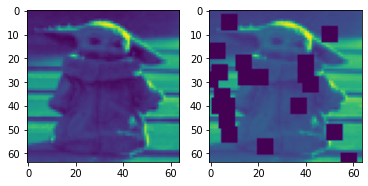

In [9]:
import requests
from PIL import Image
from io import BytesIO

import torchvision.transforms as T
r = requests.get('https://upload.wikimedia.org/wikipedia/en/a/a0/Grogu_%28Star_Wars%29.jpg')
img = Image.open(BytesIO(r.content))
tr = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor()
])
x = tr(img)
drop_block = DropBlock(block_size=7, p=0.8)
x_drop = drop_block(x)

fig, axs = plt.subplots(1, 2)
axs[0].imshow((x[2]))
axs[1].imshow(x_drop[2,:,:].squeeze().numpy())

In [32]:
# model 1 / MLP
class NeuralNetwork1(nn.Module):
    def __init__(self,in_sz,out_sz):
        super(NeuralNetwork1, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_sz, 32*32),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(32*32, 512),
            nn.ReLU(),

            nn.Linear(512, 16*16),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(16*16, 12*12),
            nn.ReLU(),

            nn.Linear(12*12, 6*6),
            nn.ReLU(),
            
            nn.Linear(6*6, out_sz),

        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [33]:
# MLP model
num_class  = 3
out_size   = num_class

in_size    = 3*sz1*sz1
MLP_1 = NeuralNetwork1(in_size,out_size).to()
   
# Hyperparameters 1
learning_rate = 1e-3
epochs = 20
batch_size = 32

loss_fn    = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(MLP_1.parameters(), lr=learning_rate)

train_dl = DataLoader(train_ds, batch_size, shuffle=True)
test_dl  = DataLoader(test_ds,batch_size,  shuffle=True)

model_dir_MLP1    = "/content/drive/MyDrive/Best_MLP.pth"
Acc_tr_hist_MLP1  = []
loss_tr_hist_MLP1 = []
Acc_te_hist_MLP1  = []
loss_te_hist_MLP1 = []


In [34]:
# MLP model training
writer = SummaryWriter('MLP')
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    MLP_1.train()
    acc_tr,loss_tr = train_loop(train_dl,  MLP_1, loss_fn, optimizer1)

    Acc_tr_hist_MLP1.append(acc_tr)
    loss_tr_hist_MLP1.append(loss_tr)
    
    writer.add_scalar('training loss',loss_tr,t+1)
    writer.add_scalar('training Accuracy',acc_tr,t+1)

    MLP_1.eval()
    acc_te,loss_te = test_loop(test_dl,  MLP_1, loss_fn)

    Acc_te_hist_MLP1.append(acc_te)
    loss_te_hist_MLP1.append(loss_te)
    
    writer.add_scalar('test loss',loss_te,t+1)
    writer.add_scalar('test Accuracy',acc_te,t+1)

    if max(Acc_te_hist_MLP1) == acc_te :
      torch.save(MLP_1.state_dict() , model_dir_MLP1  )
      epoch_Best_MLP1 = t+1
print("Job is Done!")
writer.flush()

Epoch 1
-------------------------------
loss: 1.104927  [    0/10535]
loss: 0.330782  [ 3200/10535]
loss: 0.563144  [ 6400/10535]
loss: 0.258117  [ 9600/10535]
Train : 
 Accuracy: 86.7%, Avg loss per Batch: 0.363448 

Test : 
 Accuracy: 88.3%, Avg loss per Batch: 0.325668 

Epoch 2
-------------------------------
loss: 0.318405  [    0/10535]
loss: 0.304399  [ 3200/10535]
loss: 0.251036  [ 6400/10535]
loss: 0.396416  [ 9600/10535]
Train : 
 Accuracy: 89.0%, Avg loss per Batch: 0.319457 

Test : 
 Accuracy: 90.2%, Avg loss per Batch: 0.278991 

Epoch 3
-------------------------------
loss: 0.535985  [    0/10535]
loss: 0.218204  [ 3200/10535]
loss: 0.441786  [ 6400/10535]
loss: 0.187013  [ 9600/10535]
Train : 
 Accuracy: 89.4%, Avg loss per Batch: 0.332195 

Test : 
 Accuracy: 90.3%, Avg loss per Batch: 0.290071 

Epoch 4
-------------------------------
loss: 0.514017  [    0/10535]
loss: 0.337470  [ 3200/10535]
loss: 0.342965  [ 6400/10535]
loss: 0.143977  [ 9600/10535]
Train : 
 Accur

In [35]:
! tensorboard dev upload --logdir /content/MLP \
--name "MLP model" \
--description "MLP"

2023-01-12 02:20:11.834780: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Upload started and will continue reading any new data as it's added to the logdir.

To stop uploading, press Ctrl-C.

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/27Hw9cD8QMyzlmqRUV8pEQ/

[2023-01-12T02:20:12] Started scanning logdir.
[2023-01-12T02:20:14] Total uploaded: 80 scalars, 0 tensors, 0 binary objects


Interrupted. View your TensorBoard at https://tensorboard.dev/experiment/27Hw9cD8QMyzlmqRUV8pEQ/
Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/usr/local/lib/python3.8/dist-packages/tensorboard/main.py", line 46, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "/usr/local/lib/python3.8/dist-packages/absl/app.py", line 308, in run
    _run_main(main, args)
  File "/

In [36]:
#model_dir_MLP1    = "/content/drive/MyDrive/Best_MLP.pth"
MLP_B = NeuralNetwork1(in_size,out_size).to()
MLP_B.load_state_dict(torch.load(model_dir_MLP1))
MLP_B.eval()
Best_acc_MLP1 , Best_loss_MLP1 = test_loop(test_dl,  MLP_B, loss_fn)

Test : 
 Accuracy: 94.0%, Avg loss per Batch: 0.200489 



------- metircs in the trained MLP model -------

Accuracy of best trained model = 94.0 %

            boot    sandal      shoe
recall  0.969738  0.938296  0.912167 

             boot    sandal      shoe
precision  0.9556  0.910215  0.954391


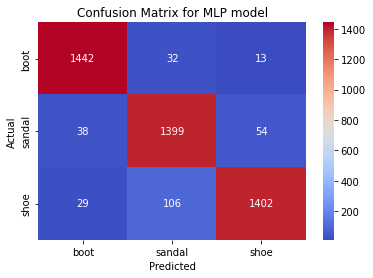

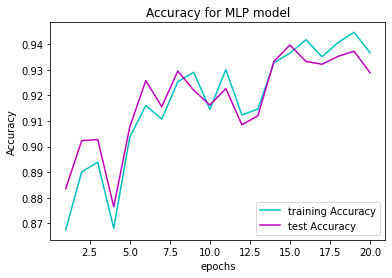

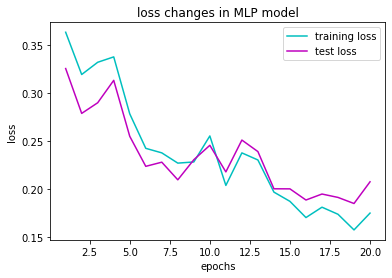

In [37]:
# result and visulization for MLP
MyModelAnalysis(test_dl, MLP_B , 'MLP' , Acc_tr_hist_MLP1 , Acc_te_hist_MLP1 , loss_tr_hist_MLP1 , loss_te_hist_MLP1 , Best_acc_MLP1 , epochs  )

In [38]:
print("------- MLP model params --------")
summary(MLP_B, (3, 64, 64))

------- MLP model params --------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                [-1, 12288]               0
            Linear-2                 [-1, 1024]      12,583,936
              ReLU-3                 [-1, 1024]               0
           Dropout-4                 [-1, 1024]               0
            Linear-5                  [-1, 512]         524,800
              ReLU-6                  [-1, 512]               0
            Linear-7                  [-1, 256]         131,328
              ReLU-8                  [-1, 256]               0
           Dropout-9                  [-1, 256]               0
           Linear-10                  [-1, 144]          37,008
             ReLU-11                  [-1, 144]               0
           Linear-12                   [-1, 36]           5,220
             ReLU-13                   [-1, 36]               0
     

## Ordinary CNN model

* CNN model As we will see in parameters and results, not only has less parameters than its corresponding MLP model, But also reaches to a greater accuracy than the MLP. Also it perceives the spatial correlation in 2D inputs. CN is shift invariant and 

In [10]:
# CNN model
class NeuralNetwork2(nn.Module):
    def __init__(self,out_sz):
        super(NeuralNetwork2, self).__init__()
        self.flatten = nn.Flatten()
        self.cnn_linear_relu_stack = nn.Sequential(
            
            nn.Conv2d(3,16, 3,1),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Conv2d(16, 32, 3, 1),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(32, 64, 3, 1),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.MaxPool2d(2, stride=2),
            
            nn.Flatten(),
            nn.Linear(14*14*64, 512),
            nn.ReLU(),

            nn.Linear(512, 12*12),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(12*12, out_sz),
        )

    def forward(self, x):
        logits = self.cnn_linear_relu_stack(x)
        return logits

In [11]:
# CNN model
num_class  = 3
out_size   = num_class
CNN_1 = NeuralNetwork2(out_size).to()
   
# Hyperparameters 1
learning_rate = 1e-3
epochs = 20
batch_size = 32

loss_fn    = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(CNN_1.parameters(), lr=learning_rate)

train_dl = DataLoader(train_ds, batch_size, shuffle=True)
test_dl  = DataLoader(test_ds,batch_size,  shuffle=True)

model_dir_CNN1    = "/content/drive/MyDrive/Best_CNN.pth"
Acc_tr_hist_CNN1  = []
loss_tr_hist_CNN1 = []
Acc_te_hist_CNN1  = []
loss_te_hist_CNN1 = []

In [12]:
# CNN training
writer = SummaryWriter('CNN')
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    CNN_1.train()
    acc_tr,loss_tr = train_loop(train_dl,  CNN_1, loss_fn, optimizer1)

    Acc_tr_hist_CNN1.append(acc_tr)
    loss_tr_hist_CNN1.append(loss_tr)
    
    writer.add_scalar('training loss',loss_tr,t+1)
    writer.add_scalar('training Accuracy',acc_tr,t+1)

    CNN_1.eval()
    acc_te,loss_te = test_loop(test_dl,  CNN_1, loss_fn)

    Acc_te_hist_CNN1.append(acc_te)
    loss_te_hist_CNN1.append(loss_te)
    
    writer.add_scalar('test loss',loss_te,t+1)
    writer.add_scalar('test Accuracy',acc_te,t+1)

    if max(Acc_te_hist_CNN1) == acc_te :
      torch.save(CNN_1.state_dict() , model_dir_CNN1  )
      epoch_Best_CNN1 = t+1
print("Job is Done!")


Epoch 1
-------------------------------
loss: 1.093148  [    0/10535]
loss: 0.315559  [ 3200/10535]
loss: 0.345243  [ 6400/10535]
loss: 0.231958  [ 9600/10535]
Train : 
 Accuracy: 93.8%, Avg loss per Batch: 0.185780 

Test : 
 Accuracy: 93.7%, Avg loss per Batch: 0.330583 

Epoch 2
-------------------------------
loss: 0.129995  [    0/10535]
loss: 0.063754  [ 3200/10535]
loss: 0.198880  [ 6400/10535]
loss: 0.185236  [ 9600/10535]
Train : 
 Accuracy: 96.2%, Avg loss per Batch: 0.112905 

Test : 
 Accuracy: 96.1%, Avg loss per Batch: 0.225020 

Epoch 3
-------------------------------
loss: 0.015559  [    0/10535]
loss: 0.137579  [ 3200/10535]
loss: 0.019790  [ 6400/10535]
loss: 0.045063  [ 9600/10535]
Train : 
 Accuracy: 97.7%, Avg loss per Batch: 0.068321 

Test : 
 Accuracy: 97.0%, Avg loss per Batch: 0.156713 

Epoch 4
-------------------------------
loss: 0.021943  [    0/10535]
loss: 0.190281  [ 3200/10535]
loss: 0.136909  [ 6400/10535]
loss: 0.011789  [ 9600/10535]
Train : 
 Accur

In [13]:
# ! tensorboard dev upload --logdir /content/CNN \
# --name "CNN model" \
# --description "CNN"

2023-01-11 19:54:07.501206: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

/content/CNN

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%

In [14]:
#model_dir_CNN1    = "/content/drive/MyDrive/Best_CNN.pth"
CNN_B = NeuralNetwork2(out_size).to()
CNN_B.load_state_dict(torch.load(model_dir_CNN1))
CNN_B.eval()
Best_acc_CNN1 , Best_loss_CNN1 = test_loop(test_dl,  CNN_B, loss_fn)

Test : 
 Accuracy: 98.3%, Avg loss per Batch: 0.056200 



------- metircs in the trained CNN model -------

Accuracy of best trained model = 98.3 %

           boot    sandal      shoe
recall  0.99193  0.984574  0.971373 

               boot    sandal      shoe
precision  0.975529  0.985897  0.986129


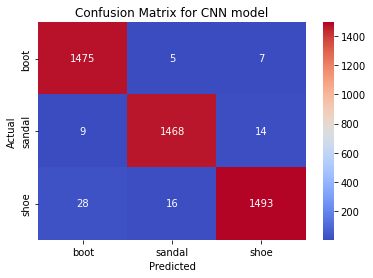

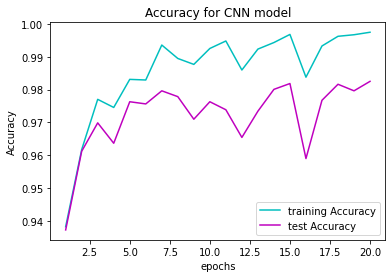

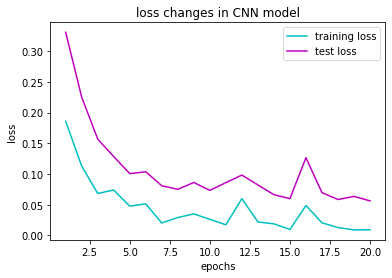

In [15]:
# result and visulization for CNN
MyModelAnalysis(test_dl, CNN_B , 'CNN' , Acc_tr_hist_CNN1 , Acc_te_hist_CNN1 , loss_tr_hist_CNN1 , loss_te_hist_CNN1 , Best_acc_CNN1 , epochs  )

In [16]:
CNN_B = NeuralNetwork2(3).to()
print("------- CNN model params ------")
summary(CNN_B, (3, 64, 64))

------- CNN model params ------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 62, 62]             448
              ReLU-2           [-1, 16, 62, 62]               0
           Dropout-3           [-1, 16, 62, 62]               0
            Conv2d-4           [-1, 32, 60, 60]           4,640
              ReLU-5           [-1, 32, 60, 60]               0
           Dropout-6           [-1, 32, 60, 60]               0
         MaxPool2d-7           [-1, 32, 30, 30]               0
            Conv2d-8           [-1, 64, 28, 28]          18,496
              ReLU-9           [-1, 64, 28, 28]               0
          Dropout-10           [-1, 64, 28, 28]               0
        MaxPool2d-11           [-1, 64, 14, 14]               0
          Flatten-12                [-1, 12544]               0
           Linear-13                  [-1, 512]       6,423,040
       

# Block Dropout CNN model

# Why Block Dropout ?
The main issue is that we are dropping independent pixels and this is not effective in removing semantic information because nearby activations contain closely related information. I think this is fairly intuitive, even if we zero out one element, the neighbors can still carry out important information.
DropBlock solves this problem by dropping continuous regions from a feature map
ref : https://github.com/FrancescoSaverioZuppichini/DropBlock/blob/main/README.ipynb

In [17]:
# Block Dropout CNN model
class NeuralNetwork3(nn.Module):
    def __init__(self,out_sz):
        super(NeuralNetwork3, self).__init__()
        self.flatten = nn.Flatten()
        self.cnn_linear_relu_stack = nn.Sequential(
            
            nn.Conv2d(3,16, 3,1),
            nn.ReLU(),
            DropBlock(block_size= 7, p=0.8),

            nn.Conv2d(16, 32, 3, 1),
            nn.ReLU(),
            DropBlock(block_size= 7 , p=0.8),
            nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(32, 64, 3, 1),
            nn.ReLU(),
            DropBlock(block_size=7, p=0.8),
            nn.MaxPool2d(2, stride=2),
            
            nn.Flatten(),
            nn.Linear(14*14*64, 512),
            nn.ReLU(),

            nn.Linear(512, 12*12),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(12*12, out_sz),
        )

    def forward(self, x):
        logits = self.cnn_linear_relu_stack(x)
        return logits

In [18]:
# Block Dropout CNN model
num_class  = 3
out_size   = num_class
CNN_2 = NeuralNetwork3(out_size).to()
   
# Hyperparameters 1
learning_rate = 1e-3
epochs = 20
batch_size = 32

loss_fn    = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(CNN_2.parameters(), lr=learning_rate)

train_dl = DataLoader(train_ds, batch_size, shuffle=True)
test_dl  = DataLoader(test_ds,batch_size,  shuffle=True)

model_dir_CNN2    = "/content/drive/MyDrive/Best_DropBlock_CNN.pth"
Acc_tr_hist_CNN2  = []
loss_tr_hist_CNN2 = []
Acc_te_hist_CNN2  = []
loss_te_hist_CNN2 = []

In [19]:
# Block Dropout CNN training
writer = SummaryWriter('Block_Dropout_CNN')
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    CNN_2.train()
    acc_tr,loss_tr = train_loop(train_dl,  CNN_2, loss_fn, optimizer1)

    Acc_tr_hist_CNN2.append(acc_tr)
    loss_tr_hist_CNN2.append(loss_tr)
    
    writer.add_scalar('training loss',loss_tr,t+1)
    writer.add_scalar('training Accuracy',acc_tr,t+1)

    CNN_2.eval()
    acc_te,loss_te = test_loop(test_dl,  CNN_2, loss_fn)

    Acc_te_hist_CNN2.append(acc_te)
    loss_te_hist_CNN2.append(loss_te)
    
    writer.add_scalar('test loss',loss_te,t+1)
    writer.add_scalar('test Accuracy',acc_te,t+1)

    if max(Acc_te_hist_CNN2) == acc_te :              
      torch.save(CNN_2.state_dict() , model_dir_CNN2 )
      epoch_Best_CNN2 = t+1
print("Job is Done!")

Epoch 1
-------------------------------
loss: 1.094621  [    0/10535]
loss: 0.375032  [ 3200/10535]
loss: 0.172575  [ 6400/10535]
loss: 0.357656  [ 9600/10535]
Train : 
 Accuracy: 92.9%, Avg loss per Batch: 0.200498 

Test : 
 Accuracy: 92.9%, Avg loss per Batch: 0.198484 

Epoch 2
-------------------------------
loss: 0.202435  [    0/10535]
loss: 0.122101  [ 3200/10535]
loss: 0.202800  [ 6400/10535]
loss: 0.417634  [ 9600/10535]
Train : 
 Accuracy: 95.5%, Avg loss per Batch: 0.130175 

Test : 
 Accuracy: 95.5%, Avg loss per Batch: 0.138589 

Epoch 3
-------------------------------
loss: 0.100962  [    0/10535]
loss: 0.125736  [ 3200/10535]
loss: 0.224507  [ 6400/10535]
loss: 0.028829  [ 9600/10535]
Train : 
 Accuracy: 97.7%, Avg loss per Batch: 0.071129 

Test : 
 Accuracy: 97.1%, Avg loss per Batch: 0.083138 

Epoch 4
-------------------------------
loss: 0.090631  [    0/10535]
loss: 0.102939  [ 3200/10535]
loss: 0.018246  [ 6400/10535]
loss: 0.058789  [ 9600/10535]
Train : 
 Accur

In [22]:
# ! tensorboard dev upload --logdir /content/Block_Dropout_CNN \
# --name "BlockDropout CNN model" \
# --description "BlockDropout CNN"

2023-01-11 23:42:18.930988: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Upload started and will continue reading any new data as it's added to the logdir.

To stop uploading, press Ctrl-C.

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/zf5Oj44nSVyFrgoO9wnuAQ/

[2023-01-11T23:42:19] Started scanning logdir.
[2023-01-11T23:42:19] Total uploaded: 80 scalars, 0 tensors, 0 binary objects


Interrupted. View your TensorBoard at https://tensorboard.dev/experiment/zf5Oj44nSVyFrgoO9wnuAQ/


In [23]:
#model_dir_CNN2    = "/content/drive/MyDrive/Best_DropBlock_CNN.pth"
BD_CNN_B = NeuralNetwork3(out_size).to()
BD_CNN_B.load_state_dict(torch.load(model_dir_CNN2))
BD_CNN_B.eval()
Best_acc_CNN2 , Best_loss_CNN2 = test_loop(test_dl,  BD_CNN_B, loss_fn)

Test : 
 Accuracy: 98.0%, Avg loss per Batch: 0.094634 



------- metircs in the trained Block Dropout CNN model -------

Accuracy of best trained model = 98.0 %

            boot    sandal      shoe
recall  0.991258  0.975184  0.974626 

               boot    sandal      shoe
precision  0.971014  0.989116  0.981009


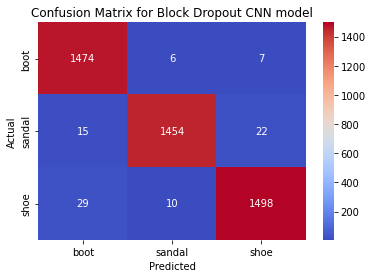

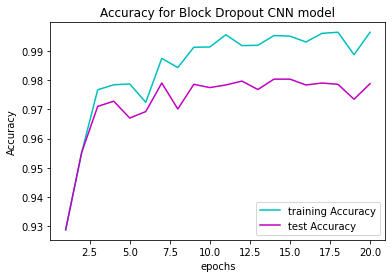

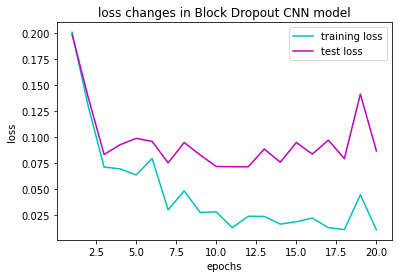

In [24]:
# result and visulization for Block Dropout CNN
MyModelAnalysis(test_dl, BD_CNN_B , 'Block Dropout CNN' , Acc_tr_hist_CNN2 , Acc_te_hist_CNN2 , loss_tr_hist_CNN2 , loss_te_hist_CNN2 , Best_acc_CNN2 , epochs  )

In [25]:
print("-------Block Dropout  CNN model params ------")
summary(BD_CNN_B, (3, 64, 64))

-------Block Dropout  CNN model params ------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 62, 62]             448
              ReLU-2           [-1, 16, 62, 62]               0
         DropBlock-3           [-1, 16, 62, 62]               0
            Conv2d-4           [-1, 32, 60, 60]           4,640
              ReLU-5           [-1, 32, 60, 60]               0
         DropBlock-6           [-1, 32, 60, 60]               0
         MaxPool2d-7           [-1, 32, 30, 30]               0
            Conv2d-8           [-1, 64, 28, 28]          18,496
              ReLU-9           [-1, 64, 28, 28]               0
        DropBlock-10           [-1, 64, 28, 28]               0
        MaxPool2d-11           [-1, 64, 14, 14]               0
          Flatten-12                [-1, 12544]               0
           Linear-13                  [-1, 512]       6,4

## Factorizd CNN model

In [26]:
# factorized CNN model
class NeuralNetwork4(nn.Module):
    def __init__(self,out_sz):
        super(NeuralNetwork4, self).__init__()
        self.flatten = nn.Flatten()
        self.cnn_linear_relu_stack = nn.Sequential(
            
            nn.Conv2d(3,3,(3,1),1),
            nn.ReLU(),
            
            nn.Conv2d(3,16,(1,3),1),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Conv2d(16, 16, (3,1), 1),
            nn.ReLU(),

            nn.Conv2d(16, 32, (1,3), 1),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(32, 32, (3,1), 1),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Conv2d(32, 64, (1,3), 1),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.MaxPool2d(2, stride=2),
            
            nn.Flatten(),
            nn.Linear(14*14*64, 512),
            nn.ReLU(),

            nn.Linear(512, 12*12),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(12*12, out_sz),
        )

    def forward(self, x):
        logits = self.cnn_linear_relu_stack(x)
        return logits

In [27]:
# factorized CNN model
num_class  = 3
out_size   = num_class
CNN_3 = NeuralNetwork4(out_size).to()
   
# Hyperparameters 1
learning_rate = 1e-3
epochs = 20
batch_size = 32

loss_fn    = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(CNN_3.parameters(), lr=learning_rate)

train_dl = DataLoader(train_ds, batch_size, shuffle=True)
test_dl  = DataLoader(test_ds,batch_size,  shuffle=True)

model_dir_CNN3    = "/content/drive/MyDrive/Best_fac_CNN.pth"
Acc_tr_hist_CNN3  = []
loss_tr_hist_CNN3 = []
Acc_te_hist_CNN3  = []
loss_te_hist_CNN3 = []

In [28]:
# factorized CNN training
writer = SummaryWriter('factorized_CNN')
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    CNN_3.train()
    acc_tr,loss_tr = train_loop(train_dl,  CNN_3, loss_fn, optimizer1)

    Acc_tr_hist_CNN3.append(acc_tr)
    loss_tr_hist_CNN3.append(loss_tr)
    
    writer.add_scalar('training loss',loss_tr,t+1)
    writer.add_scalar('training Accuracy',acc_tr,t+1)

    CNN_3.eval()
    acc_te,loss_te = test_loop(test_dl,  CNN_3, loss_fn)

    Acc_te_hist_CNN3.append(acc_te)
    loss_te_hist_CNN3.append(loss_te)
    
    writer.add_scalar('test loss',loss_te,t+1)
    writer.add_scalar('test Accuracy',acc_te,t+1)

    if max(Acc_te_hist_CNN3) == acc_te :
      torch.save(CNN_3.state_dict() , model_dir_CNN3  )
      epoch_Best_CNN3 = t+1
print("Job is Done!")

Epoch 1
-------------------------------
loss: 1.101388  [    0/10535]
loss: 1.098524  [ 3200/10535]
loss: 0.471622  [ 6400/10535]
loss: 0.700721  [ 9600/10535]
Train : 
 Accuracy: 84.1%, Avg loss per Batch: 0.410286 

Test : 
 Accuracy: 84.6%, Avg loss per Batch: 0.590745 

Epoch 2
-------------------------------
loss: 0.372919  [    0/10535]
loss: 0.122983  [ 3200/10535]
loss: 0.681135  [ 6400/10535]
loss: 0.171561  [ 9600/10535]
Train : 
 Accuracy: 91.9%, Avg loss per Batch: 0.224421 

Test : 
 Accuracy: 90.4%, Avg loss per Batch: 0.414416 

Epoch 3
-------------------------------
loss: 0.136119  [    0/10535]
loss: 0.167185  [ 3200/10535]
loss: 0.238600  [ 6400/10535]
loss: 0.148833  [ 9600/10535]
Train : 
 Accuracy: 94.3%, Avg loss per Batch: 0.170717 

Test : 
 Accuracy: 93.9%, Avg loss per Batch: 0.355872 

Epoch 4
-------------------------------
loss: 0.149203  [    0/10535]
loss: 0.386037  [ 3200/10535]
loss: 0.108397  [ 6400/10535]
loss: 0.210787  [ 9600/10535]
Train : 
 Accur

In [29]:
# ! tensorboard dev upload --logdir /content/factorized_CNN \
# --name "factorized CNN model" \
# --description "factorized CNN"

2023-01-12 01:17:47.175053: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Upload started and will continue reading any new data as it's added to the logdir.

To stop uploading, press Ctrl-C.

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/kTg8bC6YQLuEhLJyOPhnyg/

[2023-01-12T01:17:47] Started scanning logdir.
[2023-01-12T01:17:47] Total uploaded: 80 scalars, 0 tensors, 0 binary objects


Interrupted. View your TensorBoard at https://tensorboard.dev/experiment/kTg8bC6YQLuEhLJyOPhnyg/
Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/usr/local/lib/python3.8/dist-packages/tensorboard/main.py", line 46, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "/usr/local/lib/python3.8/dist-packages/absl/app.py", line 308, in run
    _run_main(main, args)
  File "/

In [30]:
#model_dir_CNN3    = "/content/drive/MyDrive/Best_fac_CNN.pth"
fac_CNN_B = NeuralNetwork4(out_size).to()
fac_CNN_B.load_state_dict(torch.load(model_dir_CNN3))
fac_CNN_B.eval()
Best_acc_CNN3 , Best_loss_CNN3 = test_loop(test_dl,  fac_CNN_B, loss_fn)

Test : 
 Accuracy: 97.3%, Avg loss per Batch: 0.083159 



------- metircs in the trained factorized CNN model -------

Accuracy of best trained model = 97.3 %

           boot    sandal      shoe
recall  0.99462  0.959759  0.966168 

               boot    sandal      shoe
precision  0.969201  0.985537  0.966168


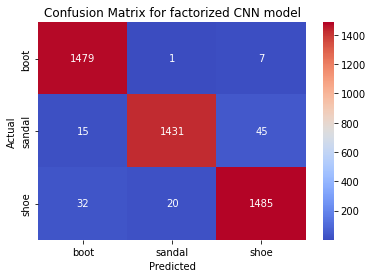

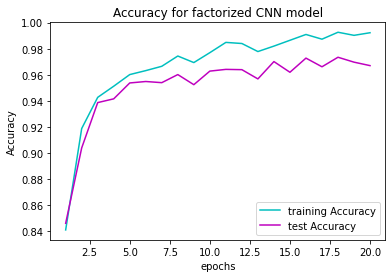

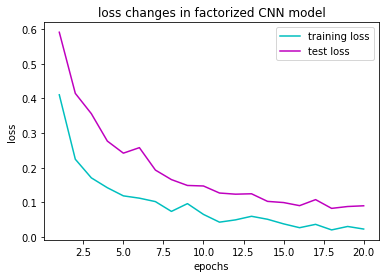

In [31]:
# result and visulization for factorizd CNN
MyModelAnalysis(test_dl, fac_CNN_B , 'factorized CNN' , Acc_tr_hist_CNN3 , Acc_te_hist_CNN3 , loss_tr_hist_CNN3 , loss_te_hist_CNN3 , Best_acc_CNN3 , epochs  )

In [ ]:

print("------- factorized CNN model params ------")
summary(fac_CNN_B, (3, 64, 64))

------- factorized CNN model params ------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 62, 64]              30
              ReLU-2            [-1, 3, 62, 64]               0
            Conv2d-3           [-1, 16, 62, 62]             160
              ReLU-4           [-1, 16, 62, 62]               0
           Dropout-5           [-1, 16, 62, 62]               0
            Conv2d-6           [-1, 16, 60, 62]             784
              ReLU-7           [-1, 16, 60, 62]               0
            Conv2d-8           [-1, 32, 60, 60]           1,568
              ReLU-9           [-1, 32, 60, 60]               0
          Dropout-10           [-1, 32, 60, 60]               0
        MaxPool2d-11           [-1, 32, 30, 30]               0
           Conv2d-12           [-1, 32, 28, 30]           3,104
             ReLU-13           [-1, 32, 28, 30]             

# Compare factorized CNN with ordinary CNN
As we see, the factorized CNN has reached almost the same accuracy of ordinary CNN with less parameters. So, it can be interpretd as a regularization technic. 
the number of parameters decreased about 10000 unit.

# tensorboard results
MLP model \
https://tensorboard.dev/experiment/27Hw9cD8QMyzlmqRUV8pEQ/ \
CNN tensorboard \
https://tensorboard.dev/experiment/xaRc1m7nQl2JmQNqBNJcqg/ \
Block Dropout CNN tensorboard \
https://tensorboard.dev/experiment/zf5Oj44nSVyFrgoO9wnuAQ/ \
factorized CNN \
https://tensorboard.dev/experiment/kTg8bC6YQLuEhLJyOPhnyg/